# Домашнее задание 1.9

## Анализ логов

### Самая лучшая команда на свете

Посмотрим сначала на исходный корпус логов.

```
memory_shaper_1  | 172.18.0.1 - - [29/Jan/2022 11:51:50] "GET / HTTP/1.1" 302 - 
memory_shaper_1  | 172.18.0.1 - - [29/Jan/2022 11:51:51] "GET /login HTTP/1.1" 200 -
memory_shaper_1  | 172.18.0.1 - - [29/Jan/2022 11:51:51] "GET /static/welcome.jpg HTTP/1.1" 200 -
memory_shaper_1  | 172.18.0.1 - - [29/Jan/2022 11:51:52] "GET /favicon.ico HTTP/1.1" 404 -
memory_shaper_1  | 172.18.0.1 - - [29/Jan/2022 11:52:05] "GET /signup HTTP/1.1" 200 -
memory_shaper_1  | 172.18.0.1 - - [29/Jan/2022 11:52:07] "GET /login HTTP/1.1" 200 -
memory_shaper_1  |   sql_session.query(models.AuthUser).filter_by(login=form_login).one_or_none()
memory_shaper_1  | 172.18.0.1 - - [29/Jan/2022 11:56:30] "POST /signup HTTP/1.1" 500 -
```

Выше представленные строки были получены кликаньем мыши по кнопкам web-приложения *Memory Shaper*. Очевидно, таким способом невозможно получить достаточное количество логов для анализа, поэтому необходимо сгенерировать еще с помощью библиотеки `selenium`.

Ниже представлен код для синтеза нового блока логов:

In [2]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import numpy
import time
import random

In [ ]:
driver = webdriver.Firefox()

users = []
alf = list('abcdefghijklmnopqrstuwxyz')

for i in range(10):
    #заходим на страницу с приложением
    driver.get("http://0.0.0.0:5000/")

    time.sleep(2)

    #на каждой итерации с вероятность 0.3 регистрируется новый пользователь
    if len(users) == 0 or numpy.random.random() < 0.3:

        login = "".join(numpy.random.choice(alf, 5))
        password = "".join(numpy.random.choice(alf, 5))

        driver.find_element_by_css_selector('h2.inactive.underlineHover').click()
        time.sleep(1)

        driver.find_element_by_name('name').send_keys(login)
        driver.find_element_by_name('login').send_keys(login)
        driver.find_element_by_name('password').send_keys(password)
        time.sleep(1)

        driver.find_elements_by_css_selector('input.fadeIn.fourth')[1].click()
        time.sleep(2)

        users.append((login, password))

    #случайным образом выбирается пользователь из уже существующих и совершается вход в систему
    login, password = random.choice(users)
    driver.find_element_by_name('login').send_keys(login)
    driver.find_element_by_name('password').send_keys(password)
    time.sleep(1)

    driver.find_element_by_css_selector('input.fadeIn.fourth').click()
    time.sleep(5)

    #выбор колоды
    driver.find_element_by_css_selector('button.menu-button').click()
    time.sleep(4)

    #случайный выбор количества карточек, которые посмотрит пользователь 
    times = numpy.random.randint(1, 50)
    i = 0

    while i < times:
        
        #показать ответ 
        driver.find_element_by_css_selector('button#button-answer').click()
        time.sleep(3)

        #с вероятностью 0.45 пользователь неправильно угадывает карточку
        if numpy.random.random() < 0.45:
            driver.find_element_by_css_selector('button.button-incorrect').click()
            time.sleep(3)
        
        else:
            driver.find_element_by_css_selector('button.button-correct').click()
            time.sleep(4)

        i += 1

driver.close()

Таким образом была создана имитация большого количества пользователей, что позволило получить достаточное количество логов.

Теперь посмотрим повнимательнее на них.

In [3]:
!head logs.txt

memory_shaper_1  | 172.20.0.1 - - [28/Nov/2021 18:52:15] "GET / HTTP/1.1" 302 -
memory_shaper_1  | 172.20.0.1 - - [28/Nov/2021 18:52:15] "GET /login HTTP/1.1" 200 -
memory_shaper_1  | 172.20.0.1 - - [28/Nov/2021 18:54:26] "POST /deck-list HTTP/1.1" 302 -
memory_shaper_1  | 172.20.0.1 - - [28/Nov/2021 18:54:26] "GET /card HTTP/1.1" 200 -
memory_shaper_1  | 172.20.0.1 - - [28/Nov/2021 18:58:34] "GET / HTTP/1.1" 302 -
memory_shaper_1  | 172.20.0.1 - - [28/Nov/2021 18:58:34] "GET /login HTTP/1.1" 200 -
memory_shaper_1  | 172.20.0.1 - - [28/Nov/2021 18:58:34] "GET /static/welcome.jpg HTTP/1.1" 200 -
memory_shaper_1  | 172.20.0.1 - - [28/Nov/2021 18:58:34] "GET /favicon.ico HTTP/1.1" 404 -
memory_shaper_1  | 172.20.0.1 - - [28/Nov/2021 18:58:38] "GET /signup HTTP/1.1" 200 -
memory_shaper_1  | 172.20.0.1 - - [28/Nov/2021 18:58:39] "POST /signup HTTP/1.1" 302 -


#### Проанализируем запросы.

In [4]:
file = open('logs.txt', 'r')

requests = list()
pages = list()

for f in file:
    index = f.find('"')
    log = f[index+1:]
    index = log.find('"')
    log = log[:index]
    
    request = log.split()[0]
    page = log.split()[1]
    
    requests.append(request)
    
    if 'static' not in page and 'favicon' not in page:
        pages.append(page)
    
print(set(requests))
print(set(pages))

{'POST', 'GET'}
{'/deck-list', '/', '/signup', '/check_answer', '/login', '/card'}


**Вывод №1:**  Можно увидеть, что выполняется всего два типа HTTP запроса: GET и POST.

Можно заметить, что все запросы `static` направлены на отрисовку изображений на странице. Нас это не очень интересует, поэтому проигнорируем их.

**Вывод №2:** Запросы выполнялись к страницам: CARD, CHECK_ANSWER, LOGIN, DECK-LIST, SIGNUP.

Теперь найдем статистику переходов между страницами.

In [15]:
import pandas as pd

pages_unique = set(pages)
        
df = pd.DataFrame(columns=pages_unique, index=pages_unique)
df.fillna(0, inplace=True)

for i in range(len(pages) - 1):
    df[pages[i+1]][pages[i]] += 1

sums = df.sum(axis=1).copy()

for col in df:
    df[col] = df[col] / sums

df

,/deck-list,/,/signup,/check_answer,/login,/card
/deck-list,0.466667,0.000000,0.000000,0.000000,0.000000,0.533333
/,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
/signup,0.000000,0.000000,0.500000,0.000000,0.500000,0.000000
/check_answer,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
/login,0.242424,0.303030,0.242424,0.000000,0.212121,0.000000
/card,0.000000,0.090909,0.000000,0.909091,0.000000,0.000000


Нарисуем граф процессов приложения *Memory Shaper*.

  0%|          | 0/12 [00:00<?, ?it/s]

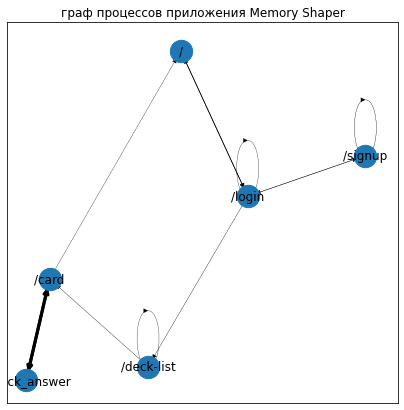

In [11]:
import networkx as nx
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

edges = []

for i in df.columns:
    for j in df.columns:
        if df.loc[i, j] == 0:
            continue
            
        weight = df.loc[i, j] * 10
        edges.append((i, j, weight))

G = nx.DiGraph()

fig = plt.figure(figsize=(7, 7))

G.add_weighted_edges_from(edges)

pos = nx.spring_layout(G)

nx.draw_networkx_nodes(G, pos, cmap=plt.get_cmap('jet'), node_size = 500)
nx.draw_networkx_labels(G, pos)

for (node1, node2, edge_attr) in tqdm(G.edges(data=True)):
    nx.draw_networkx_edges(G, pos, edgelist=[(node1, node2)],width=edge_attr['weight'])

plt.title('Граф процессов приложения Memory Shaper')
plt.show()

**Вывод:** Сразу бросается в глаза, что самый частый взаимнообратный переход из `check_answer` в `card`. Это вполне закономерно, так как, посмотрев карточку, пользователь хочет узнать ответ, и, узнав ответ, пользователь хочет посмотреть следующую карточку.

Следующим ребром по жирности является переход из корневой страницы в `login`, что тоже соответсвует нашим представлениям о работе сайта. Ребра `login` &rarr; `deck-list` и `deck-list` &rarr; `card` также говорят о корректно работающей логике приложения.

Граф помог выявить неблагоприятные сценарии пользования нашим приложением. Так, например, петли в `login` и `signup` показали, что некоторые пользователи после регистрации/входа не проявляют интерес дальше и уходят.